## Installation

In [2]:
%pip install git+https://github.com/maumlima/swirl-dynamics.git@main

## Imports

In [2]:
import os, functools

from clu import metric_writers
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp
import tensorflow as tf

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn
from swirl_dynamics.data.hdf5_utils import read_single_array

2024-08-02 16:11:47.404504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:11:47.416865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:11:47.420314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 16:11:48.701422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/work/FAC/FGSE/IDYST/tbeucler/downscaling/mlima/s2s-downscaling/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_i

## Example I - Unconditional diffusion model with guidance

### Dataset

First we need a dataset containing samples whose distribution is to be modeled by the diffusion model. For demonstration purpose, we use the MNIST dataset in hdf5, which can be downloaded at https://www.kaggle.com/datasets/benedictwilkinsai/mnist-hd5f.

Our code setup accepts any Python iterable objects to be used as dataloaders. The expectation is that they should continuously yield a dictionary with a field named `x` whose corresponding value is a numpy array with shape `(batch, *spatial_dims, channels)`.

In [3]:
def get_mnist_dataset(file_path: str, key: str, split:float, batch_size: int):
    # Read the dataset from the .hdf5 file.
    images = read_single_array(file_path, key)

    # Determine the split indices.
    num_images = images.shape[0]
    if split > 0:
        end_idx = int(num_images * split)
        images = images[:end_idx]
    elif split < 0:
        start_idx = int(num_images * (1 + split))
        images = images[start_idx:]

    # Normalize the images to [0, 1].
    images = images.astype(jnp.float32) / 255.0

    # Expand dims
    images = jnp.expand_dims(images, axis=-1)

    # Create a TensorFlow dataset from the images.
    ds = tf.data.Dataset.from_tensor_slices({"x": images})

    # Repeat, batch, and prefetch the dataset.
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.as_numpy_iterator()

    return ds

# The standard deviation of the normalized dataset.
# This is useful for determining the diffusion scheme and preconditioning
# of the neural network parametrization.
DATA_STD = 0.31

# Folder where the downloaded dataset is stored
mnist_folder = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mlima/data/mnist"

### Architecture

Next let's define the U-Net backbone. The "Preconditioning" is to ensure that the inputs and outputs of the network are roughly standardized (for more details, see Appendix B.6. in [this paper](https://arxiv.org/abs/2206.00364)).

In [4]:
denoiser_model = dfn_lib.PreconditionedDenoiserUNet(
  out_channels=1,
  num_channels=(64, 128),
  downsample_ratio=(2, 2),
  num_blocks=4,
  noise_embed_dim=128,
  padding="SAME",
  use_attention=True,
  use_position_encoding=True,
  num_heads=8,
  sigma_data=DATA_STD,
)

### Training

For diffusion model training, the above-defined U-Net backbone serves as a denoiser, which takes as input a batch of (isotropic Gaussian noise) corrupted samples and outputs its best guess for what the uncorrupted image would be.

Besides the backbone architecture, we also need to specify how to sample the noise levels (i.e. standard deviations) used to corrupt the samples and the weighting for each noise level in the loss function (for available options and configurations, see [`swirl_dynamics.lib.diffusion.diffusion`](https://github.com/google-research/swirl-dynamics/blob/main/swirl_dynamics/lib/diffusion/diffusion.py)):

In [5]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=DATA_STD,
)

model = dfn.DenoisingModel(
    # `input_shape` must agree with the expected sample shape (without the batch
    # dimension), which in this case is simply the dimensions of a single MNIST
    # sample.
    input_shape=(28, 28, 1),
    denoiser=denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=DATA_STD),
)

We are now ready to define the learning parameters.

In [8]:
# !rm -R -f $workdir  # optional: clear the working directory

In [6]:
num_train_steps = 100_000  #@param
workdir = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mlima/s2s-downscaling/examples/mnist"
train_batch_size = 32  #@param
eval_batch_size = 32  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param
warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param

To start training, we first need to initialize the trainer.

In [7]:
# NOTE: use `trainers.DistributedDenoisingTrainer` for multi-device
# training with data parallelism.
trainer = dfn.DenoisingTrainer(
    model=model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    # We keep track of an exponential moving average of the model parameters
    # over training steps. This alleviates the "color-shift" problems known to
    # exist in the diffusion models.
    ema_decay=ema_decay,
)

Now we are ready to kick start training. A couple of "callbacks" are passed to assist with monitoring and checkpointing.

The first step will be a little slow as Jax needs to JIT compile the step function (the same goes for the first step where evaluation is performed). Fortunately, steps after that should continue much faster.

Alternatively, feel free to use the `train.py` script in this folder, as it's probably easier to use it in GPUs, which will speed up the training.

In [11]:
templates.run_train(
    train_dataloader=get_mnist_dataset(
      file_path=os.path.join(mnist_folder,'train.hdf5'),
      key="image",
      split=0.75,
      batch_size=train_batch_size,
    ),
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=get_mnist_dataset(
      file_path=os.path.join(mnist_folder,'train.hdf5'),
      key="image",
      split=-0.25,
      batch_size=train_batch_size,
    ),
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        # This callback displays the training progress in a tqdm bar
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        # This callback saves model checkpoint periodically
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

### Inference

#### Unconditional generation

After training is complete, the trained denoiser may be used to generate unconditional samples.

First, let's restore the model from checkpoint.

In [12]:
# Restore train state from checkpoint. By default, the move recently saved
# checkpoint is restored. Alternatively, one can directly use
# `trainer.train_state` if continuing from the training section above.
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)
# Construct the inference function
denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=denoiser_model
)

Diffusion samples are generated by plugging the trained denoising function in a stochastic differential equation (parametrized by the diffusion scheme) and solving it backwards in time. The added custom sampler allows one to start from a given sample, noise it up with the forward SDE and then denoise with the corresponding backward SDE. This is advantageous if you want to denoise from a given "custom" level which doesn't errase the original image completely - this can be controlled with the `clip_max` argument. 

In [14]:
new_diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(clip_max=2),
    data_std=DATA_STD,
)

sampler = dfn_lib.SdeCustomSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=new_diffusion_scheme,
    denoise_fn=denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,  # Set to `True` if the full sampling paths are needed
)

The sampler may be run by calling its `.generate()` function. Optionally, we may JIT compile this function so that it runs faster if repeatedly called.

In [15]:
generate = jax.jit(sampler.generate, static_argnames=('num_samples',))

In [17]:
test_ds = get_mnist_dataset(
      file_path=os.path.join(mnist_folder,'test.hdf5'),
      key="image",
      split=1,
      batch_size=1,
)
samples = generate(
  init_sample=next(iter(test_ds))["x"][0,...],
  rng=jax.random.PRNGKey(8888), num_samples=4
)

In [21]:
next(iter(test_ds))["x"].shape[1:]

(28, 28, 1)

Visualize the generated samples:

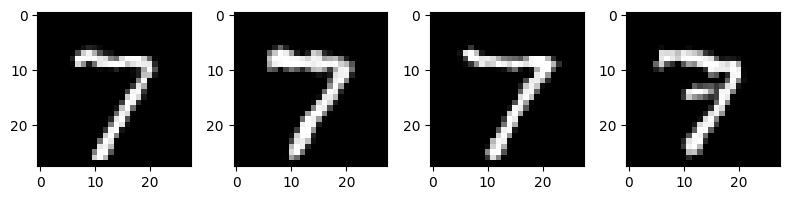

In [18]:
# Plot generated samples
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
  im = ax[i].imshow(samples[i, :, :, 0] * 255, cmap="gray", vmin=0, vmax=255)

plt.tight_layout()
plt.show()

#### Guided generation

To achieve 'guided' generation, we can modify a trained denoising function and tailor it to produce samples with specific desired characteristics. For instance, in an out-filling task where the goal is to generate full images from a given patch, we can guide the denoiser to create samples whose crops at certain positions precisely align with the provided patch.

In [23]:
guidance_fn = dfn_lib.InfillFromSlices(
    # This specifies location of the guide input using python slices.
    # Here it implies that the guide input corresponds the 7x7 patch in the
    # center of the image.
    # slices=(slice(None), slice(11, 18), slice(11, 18)),
    slices=(slice(None), slice(0, -1), slice(0, -1)),

    # This is a parameter that controls how "hard" the denoiser pushes for
    # the conditioning to be satisfied. It is a tradeoff between strictness of
    # constraint satisfication and diversity in the generated samples.
    guide_strength=0.1,
)

guidance_fn2 = dfn_lib.AlphaBlendedGuidance(final_alpha=0.1)

This transform function is passed through the `guidance_transforms` arg of the sampler.

In [24]:
guided_sampler = dfn_lib.SdeSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    guidance_transforms=(guidance_fn2,),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

guided_generate = jax.jit(guided_sampler.generate, static_argnames=('num_samples',))

We construct an example guidance input from a real sample and use it to guide the sampling:

In [25]:
test_ds = get_mnist_dataset(split="test", batch_size=1)
test_example = next(iter(test_ds))["x"]
example_guidance_inputs = {'original_image': test_example}

2024-08-01 11:02:48.374799: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
guided_samples = guided_generate(
  rng=jax.random.PRNGKey(66),
  num_samples=4,
  # Note that the shape of the guidance input must be compatible with
  # `sample[guidance_fn.slices]`
  guidance_inputs=example_guidance_inputs,
)

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>


Visualize guided samples:

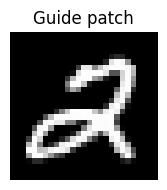

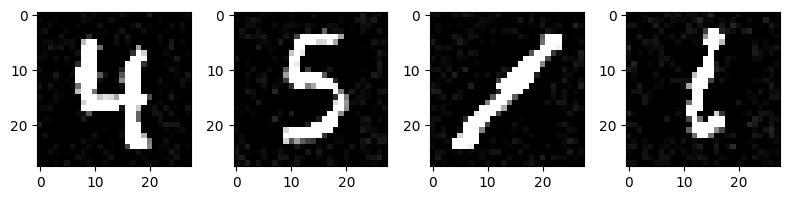

In [28]:
# Plot guide patch.
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
im = ax.imshow(
    test_example[0, 0:-1, 0:-1, 0] * 255, cmap="gray", vmin=0, vmax=255
)
ax.axis("off")
ax.set_title("Guide patch")
plt.tight_layout()
plt.show()

# Plot generated samples.
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
  im = ax[i].imshow(
      guided_samples[i, :, :, 0] * 255, cmap="gray", vmin=0, vmax=255
  )
  # # Mark out the patch where guidance is enabled.
  # square = patches.Rectangle(
  #     xy=(0, 0), width=27, height=27, fill=False, edgecolor='red'
  # )
  # ax[i].add_patch(square)
  # ax[i].axis("off")
  # ax[i].set_title(f"Sample #{i}")

plt.tight_layout()
plt.show()